In [2]:
#loading libraries
suppressMessages(library("DESeq2"))
suppressMessages(library(edgeR))
suppressMessages(library(lubridate))
suppressMessages(library(dplyr))
suppressMessages(library(tidyverse))
suppressMessages(library(gsheet))
suppressMessages(library(data.table))
suppressMessages(library(vegan))
suppressMessages(library(EnvStats))
suppressMessages(library(stringr))

In [3]:
rm(list=ls())
sample_key = fread("/workdir/omm35/urine_plasma_cfRNA_comparison/metadata_key/plasma_urine_key.tsv")

sample_key = sample_key  %>% filter(use_pair=="TRUE")

qc_pass_samples = fread("/workdir/omm35/paper_urine_cfrna/metadata/QC_pass_samples.csv")

In [4]:
sample_key_urine = sample_key  
sample_key_plasma = sample_key



# #For urine
sample_key_urine$sample_id = sample_key_urine$sample_id_urine
#sample_key_urine = sample_key_urine[!(duplicated(sample_key_urine$sample_id_plasma)),]
#sample_key_urine = column_to_rownames(sample_key_urine, var = "sample_id_urine")
sample_key_urine$event_sym = factor(sample_key_urine$event_sym)

# #For plasma
# sample_key_plasma = sample_key_plasma[!(duplicated(sample_key_plasma$sample_id_plasma)),]
sample_key_plasma$sample_id = sample_key_plasma$sample_id_plasma
#sample_key_plasma = column_to_rownames(sample_key_plasma, var = "sample_id_plasma")
sample_key_plasma$event_sym = factor(sample_key_plasma$event_sym)


urinePlasmaMapping = sample_key_urine  %>% select(Record_ID,SubjectID,event_sym,sample_id_plasma,sample_id_urine)
colnames(urinePlasmaMapping)[3]="Event"

In [5]:
colnames(urinePlasmaMapping)

[1] "Record_ID"        "SubjectID"        "Event"            "sample_id_plasma"
[5] "sample_id_urine"

In [6]:
patient_metadata = fread("/workdir/omm35/urine_cfRNA_analysis/metadata/patient_metadata.tsv")
patient_metadata = patient_metadata[,c("Record_ID","age","sex","group","hct_date")]
patient_metadata$Record_ID  = as.character(patient_metadata$Record_ID)

Function to calculate Bray Curtis similarities

In [7]:
calculate_bray_curtis = function(pathtofile,samples_after_qc){
    tissues = fread(pathtofile, header=TRUE)
    tissues$sample_id=gsub("\\.",'-',tissues$sample_id)
    #print(head(tissues))
    ###-pre-processing the dataframe 
    #tissues = tissues[tissues$sample_id  %in% samples_after_qc, ]
    tissues = t(tissues)
    rownames(tissues)=NULL  #remove row names 
    tissues  = as.data.frame(tissues) #convert to dataframe
    names(tissues ) <- tissues[1,] #making the first row as column names
    tissues  <- tissues[-1,] #deleting the first row
    tissues  = lapply(tissues,as.numeric) #converting to numeric 
    tissues  = as.data.frame(tissues)
    tissues =t(tissues) #transposing the dataframe and have it as a matrix 
    tissues_CTO_similarity=1 - as.matrix(vegdist(tissues, method = "bray", )) #dissimilarity
    tissues_CTO_similarity=as.data.frame(tissues_CTO_similarity)
    tissues_CTO_similarity=tissues_CTO_similarity%>% tibble::rownames_to_column(var = "Row")
    #print(head(tissues_CTO_similarity))
    tissues_CTO_similarity<-tissues_CTO_similarity%>%
    pivot_longer(-Row, names_to = "cluster_id", values_to = "bray.similarity") 
    #removing similarities in the same samples
    tissues_CTO_similarity <- tissues_CTO_similarity[tissues_CTO_similarity$Row != tissues_CTO_similarity$cluster_id,]
    tissues_CTO_similarity<- tissues_CTO_similarity %>% distinct(bray.similarity, .keep_all=TRUE)
# #     return tissues_CTO_similarity
}

urine samples

In [8]:
#path = "/local/workdir/omm35/takara_human_V2/output/GVHD/GVHD_BP_celltypes.protein_coding.tsv"
path ="/workdir/omm35/test_cfrna_deconvolution/output/gvhd_urine_updated_ref_BP.protein_coding.tsv"

# samples_after_qc = qc_pass_samples[qc_pass_samples$biofluid=="Urine-GVHD",]$sample_id
# samples_after_qc = samples_after_qc[samples_after_qc  %in% sample_key_urine$sample_id ]



urine.braycurtis.similarity.df = calculate_bray_curtis(path,sample_key_urine$sample_id)

####

colnames(urine.braycurtis.similarity.df)[2]="sample_id_urine"
urine.braycurtis.similarity.df$sample_id_urine = gsub("\\.","-", urine.braycurtis.similarity.df$sample_id_urine)
urine.braycurtis.similarity.df$Row = gsub("\\.","-", urine.braycurtis.similarity.df$Row)

# #urinePlasmaMapping = sample_key
urine.braycurtis.similarity.df <-left_join(urine.braycurtis.similarity.df,urinePlasmaMapping,by=c("sample_id_urine"))


# # #subset_urinePlasmaMapping = urinePlasmaMapping %>% select(urine_cluster_id, SubjectID, Record_ID, sex)
# #urinePlasmaMapping = sample_key
subset_urinePlasmaMapping = urinePlasmaMapping %>% select(sample_id_urine, SubjectID, Record_ID,Event)

# # #colnames(subset_urinePlasmaMapping)<-c("Row", "SubjectID_", "Record_ID_", "sex_")
colnames(subset_urinePlasmaMapping)<-c("Row", "SubjectID_", "Record_ID_","Event_")

urine.braycurtis.similarity.df<-left_join(urine.braycurtis.similarity.df,subset_urinePlasmaMapping,by="Row")

urine.braycurtis.similarity.df <- urine.braycurtis.similarity.df %>% mutate(rltnship=case_when( Record_ID==Record_ID_~"Intra-Patient",TRUE~"Inter-Patient"))


urine.braycurtis.similarity.df$biofluid="Urine-GVHD"


# # # # urine.braycurtis.similarity.df = urine.braycurtis.similarity.df %>% select(Row, SubjectID_, Record_ID_, sex_,rltnship,bray.similarity,SubjectID, Record_ID, sex,biofluid)
urine.braycurtis.similarity.df = urine.braycurtis.similarity.df %>% select(Row,sample_id_urine, SubjectID_, Record_ID_,rltnship,bray.similarity,SubjectID, Record_ID,Record_ID,biofluid,Event,Event_)

GVHD Plasma 

In [9]:
calculate_bray_curtis = function(pathtofile,samples_after_qc){
    tissues = fread(pathtofile, header=TRUE)
    #print(head(tissues))
    ###-pre-processing the dataframe 
    #tissues = tissues[tissues$sample_id  %in% samples_after_qc, ]
    tissues = t(tissues)
    rownames(tissues)=NULL  #remove row names 
    tissues  = as.data.frame(tissues) #convert to dataframe
    names(tissues ) <- tissues[1,] #making the first row as column names
    tissues  <- tissues[-1,] #deleting the first row
    tissues  = lapply(tissues,as.numeric) #converting to numeric 
    tissues  = as.data.frame(tissues)
    tissues =t(tissues) #transposing the dataframe and have it as a matrix 
    tissues_CTO_similarity=1 - as.matrix(vegdist(tissues, method = "bray", )) #dissimilarity
    tissues_CTO_similarity=as.data.frame(tissues_CTO_similarity)
    tissues_CTO_similarity=tissues_CTO_similarity%>% tibble::rownames_to_column(var = "Row")
    #print(head(tissues_CTO_similarity))
    tissues_CTO_similarity<-tissues_CTO_similarity%>%
    pivot_longer(-Row, names_to = "cluster_id", values_to = "bray.similarity") 
    #removing similarities in the same samples
    tissues_CTO_similarity <- tissues_CTO_similarity[tissues_CTO_similarity$Row != tissues_CTO_similarity$cluster_id,]
    tissues_CTO_similarity<- tissues_CTO_similarity %>% distinct(bray.similarity, .keep_all=TRUE)
# #     return tissues_CTO_similarity
}

In [10]:
#path = "/workdir/cfrna/alignment/takara_human_V2/output/gvhd_hct/gvhd_hct_BP_celltypes.protein_coding.tsv"
# path = "/workdir/omm35/test_cfrna_deconvolution/GVHD-plasma/GVHD-plasma_BP.protein_coding.tsv"
path = "/workdir/omm35/test_cfrna_deconvolution/output/gvhd_plasma_updated_ref_BP.protein_coding.tsv"
#tissuesplasma = fread(, header=TRUE)

#samples_after_qc = qc_pass_samples[qc_pass_samples$biofluid=="Plasma-GVHD",]$sample_id
#length(samples_after_qc)
#samples_after_qc = samples_after_qc[samples_after_qc  %in% sample_key_plasma$sample_id ]
#length(samples_after_qc)
plasma.braycurtis.similarity.df = calculate_bray_curtis(path,sample_key_plasma$sample_id)

####



colnames(plasma.braycurtis.similarity.df)[2]="sample_id_plasma"
plasma.braycurtis.similarity.df$sample_id_plasma = gsub("\\.","-", plasma.braycurtis.similarity.df$sample_id_plasma)
plasma.braycurtis.similarity.df$Row = gsub("\\.","-", plasma.braycurtis.similarity.df$Row)

# #urinePlasmaMapping = sample_key
plasma.braycurtis.similarity.df <-left_join(plasma.braycurtis.similarity.df,urinePlasmaMapping,by=c("sample_id_plasma"))


# # #subset_urinePlasmaMapping = urinePlasmaMapping %>% select(urine_cluster_id, SubjectID, Record_ID, sex)
# #urinePlasmaMapping = sample_key
subset_urinePlasmaMapping = urinePlasmaMapping %>% select(sample_id_plasma, SubjectID, Record_ID,Event)

# # #colnames(subset_urinePlasmaMapping)<-c("Row", "SubjectID_", "Record_ID_", "sex_")
colnames(subset_urinePlasmaMapping)<-c("Row", "SubjectID_", "Record_ID_","Event_")

plasma.braycurtis.similarity.df<-left_join(plasma.braycurtis.similarity.df,subset_urinePlasmaMapping,by="Row")

plasma.braycurtis.similarity.df <- plasma.braycurtis.similarity.df %>% mutate(rltnship=case_when( Record_ID==Record_ID_~"Intra-Patient",TRUE~"Inter-Patient"))


plasma.braycurtis.similarity.df$biofluid="Plasma-GVHD"


# # # # urine.braycurtis.similarity.df = urine.braycurtis.similarity.df %>% select(Row, SubjectID_, Record_ID_, sex_,rltnship,bray.similarity,SubjectID, Record_ID, sex,biofluid)
plasma.braycurtis.similarity.df = plasma.braycurtis.similarity.df %>% select(Row,sample_id_plasma, SubjectID_, Record_ID_,rltnship,bray.similarity,SubjectID, Record_ID,Record_ID,biofluid,Event,Event_)



KTx Urine 

In [12]:
path = "/local/workdir/omm35/takara_human_V2/output/KTx/KTx_BP_celltypes.protein_coding.tsv"
samples_after_qc = qc_pass_samples[qc_pass_samples$biofluid=='Urine-KTx',]$sample_id
ktx.urine.braycurtis.similarity.df = calculate_bray_curtis(path,samples_after_qc)

In [13]:
ktx.urine.braycurtis.similarity.df$cluster_id = gsub("\\.","-", ktx.urine.braycurtis.similarity.df$cluster_id)
ktx.urine.braycurtis.similarity.df$Row = gsub("\\.","-", ktx.urine.braycurtis.similarity.df$Row)

In [14]:
#creating a metadatafile
ktx_metadf=gsheet2tbl("https://docs.google.com/spreadsheets/d/16o_w6xrpmUiZUaCUCdkxzo1-dY8iU_zBykkxBO32gC0/edit?usp=sharing")
ktx_metadf = ktx_metadf[,c(1,2,3)]
colnames(ktx_metadf)=c("sequence_ID","patient_ID","visit")


##
ktx_qc_filtered = read.csv("/workdir/omm35/urine_cfRNA_analysis/Ktx_and_GVHD_urine_cfRNA_analysis/ktx_samples_after_QC_filtering.csv")
#only keep samples that have passed QC
ktx_qc_filtered = ktx_qc_filtered[ ktx_qc_filtered$sample_id %in% samples_after_qc,]

ktx_metadf=gsheet2tbl("https://docs.google.com/spreadsheets/d/16o_w6xrpmUiZUaCUCdkxzo1-dY8iU_zBykkxBO32gC0/edit?usp=sharing")
ktx_metadf = ktx_metadf[,c(1,2,3)]
colnames(ktx_metadf)=c("sequence_ID","patient_ID","visit")


ktx_urinePlasmaMapping= ktx_qc_filtered  %>% left_join(ktx_metadf, by=c("patient_ID","sequence_ID"))
colnames(ktx_urinePlasmaMapping)[1]="cluster_id"

In [15]:
subset_ktx_urinePlasmaMapping = ktx_urinePlasmaMapping %>% select(cluster_id, patient_ID, visit)

ktx.urine.braycurtis.similarity.df <- left_join(ktx.urine.braycurtis.similarity.df,ktx_urinePlasmaMapping,by=c("cluster_id"))


colnames(subset_ktx_urinePlasmaMapping)<-c("Row", "patient_ID_", "visit_")

ktx.urine.braycurtis.similarity.df<-left_join(ktx.urine.braycurtis.similarity.df,subset_ktx_urinePlasmaMapping,by="Row")

ktx.urine.braycurtis.similarity.df <- ktx.urine.braycurtis.similarity.df %>% mutate(rltnship=case_when( patient_ID==patient_ID_~"Intra-Patient",TRUE~"Inter-Patient"))


ktx.urine.braycurtis.similarity.df$biofluid="Urine-KTx"

# plasma.braycurtis.similarity.df = plasma.braycurtis.similarity.df[!is.na(plasma.braycurtis.similarity.df$urine_cluster_id),]


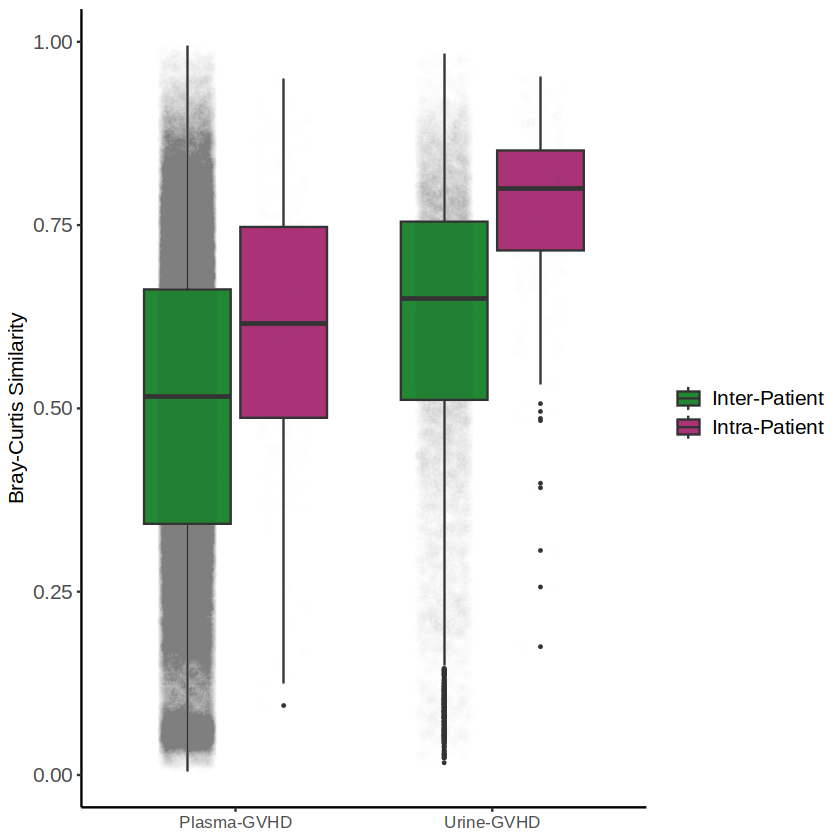

In [16]:
ktx.urine = ktx.urine.braycurtis.similarity.df %>% select(bray.similarity,rltnship,biofluid)
gvhd.urine = urine.braycurtis.similarity.df  %>%  select(bray.similarity,rltnship,biofluid)
gvhd.plasma = plasma.braycurtis.similarity.df %>%  select(bray.similarity,rltnship,biofluid)

#combined.plasma.urine.similarity = rbind(ktx.urine,gvhd.urine,gvhd.plasma)
combined.plasma.urine.similarity = rbind(gvhd.urine,gvhd.plasma)
#'#CCBB44', '#66CCEE', 
combined.plasma.urine.similarity%>% ggplot(.,aes(biofluid, bray.similarity, fill=rltnship))+geom_boxplot(lwd=0.5, outlier.size = 0.3)+
   geom_point(position = position_jitterdodge( jitter.width = 0.2,
  jitter.height = 0,
  dodge.width = 0.75,
  seed = NA), alpha=0.005) + scale_fill_manual(values=c('#228833','#AA3377'))+ theme_classic()+
  ylab("Bray-Curtis Similarity")+ theme(
    axis.title.x = element_blank(),
    axis.text.x = element_text(size = 10,family = "Helvetica"),
    axis.title.y = element_text(size = 12,family = "Helvetica"),
    axis.text.y = element_text(size=12,family = "Helvetica"),
    #legend.position = c(0.8, 0.2),
    legend.title = element_blank(),
    legend.text = element_text(colour="black", size=12),
    #legend.position = "none",
    #strip.text = element_text(size = 10, colour = "BLACK")
  ) 



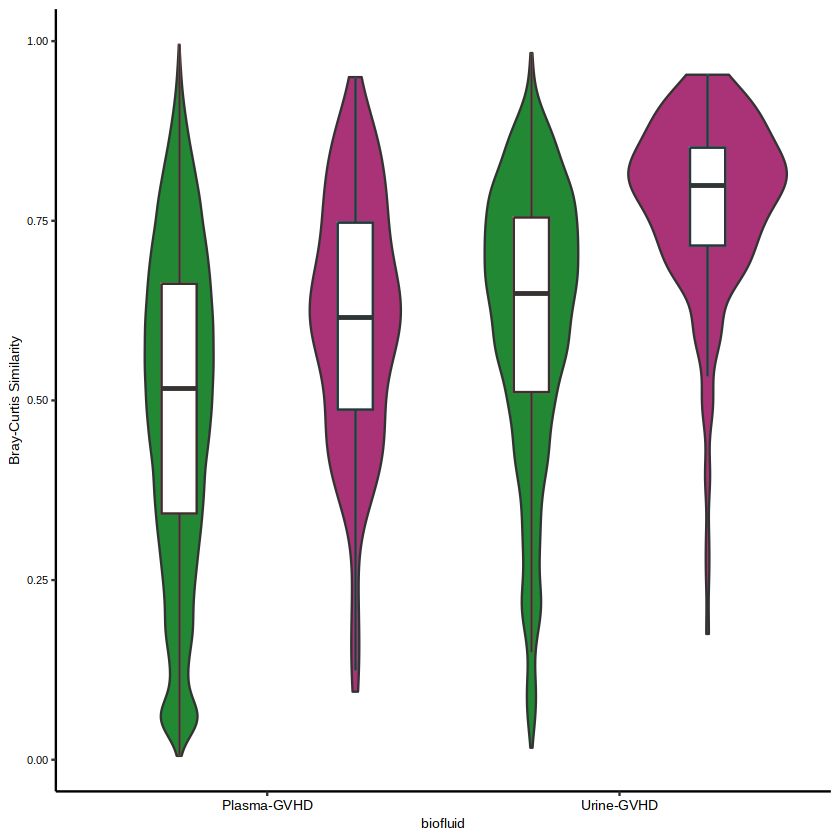

In [19]:
 ggplot(combined.plasma.urine.similarity,aes(biofluid, bray.similarity, fill=rltnship)) +
geom_violin(position = position_dodge(width = 1)) +
  geom_boxplot(data = combined.plasma.urine.similarity, 
               aes(x = biofluid, y = bray.similarity, col=rltnship), fill="white", 
               position = position_dodge(width = 1), width=0.2,outlier.shape=NA)+
  geom_boxplot(position = position_dodge(width = 1), alpha=0, width=0.2) +
 scale_fill_manual(values=c('#228833','#AA3377'))+ theme_classic()+
  ylab("Bray-Curtis Similarity")+theme(
    axis.title.x = element_text(size = 8,family = "Helvetica", color="black"),
    axis.text.x = element_text(size = 8,family = "Helvetica", color="black"),
    axis.title.y = element_text(size = 8,family = "Helvetica", color="black"),
    axis.text.y = element_text(size=6,family = "Helvetica", color="black"),
    #legend.position = c(0.8, 0.8),
    legend.position = "none",
    legend.text = element_text(size=6),
    legend.title = element_blank(),
    legend.box.background = element_rect(),
  )

Plasma and urine  in the same event 